# Processing of triggerlessly acquired detector's data
## PREPROCESSING

Load and pepare the dataset inside a Pandas' DataFrame

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Prepare the path to the file
directory = "~/data/"
file_name = "data_000000.txt"

# Load the dataset
data = pd.read_csv(directory + file_name)

# Useful constants
Tmax = 390 # ns
L = 42 # mm
Vd = L/(2*Tmax) # mm/ns
pos_offset = 21 # mm

# Add column of time (ns)
# There is a problem with the precision of the measures
# Real time: data['TIME_NS'] = data["ORBIT_CNT"]*3564*25 + data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
data['TIME_NS'] = data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30

# Show first 5 rows
data.head(5)

def compute_t0(tR1, tR2, tR3):
    return (tR1 - tR3)/2 + tR2 - Tmax

# To get the layer we must get the remainder of the TDC_CHANNEL with 4
# Then we must reoder the result as described above
data['LAYER'] = data['TDC_CHANNEL'] % 4

# Create mask to adjust labels
mask = data == 'inf' # Trick: I want an equivalent DataFrame with all False

# Map 1 --> 4
data.loc[data['LAYER'] == 1,'LAYER'] = 4

# Map 0 -> 1
data.loc[data['LAYER'] == 0,'LAYER'] = 1

# Check the correctness
data.head(5)

# Create column for chamber
# Create mask to adjust labels
mask = data == 'inf' # Trick: I want an equivalent DataFrame with all False

# Before create empty column
data['CHAMBER'] = 0

# Detector 1
# Select all rows with FPGA = 0 and TDC_CHANNEL <= 64
mask['CHAMBER'] = ((data['FPGA'] == 0) & (data['TDC_CHANNEL'] <= 64))
data[mask] = 1

# Detector 2
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
mask['CHAMBER'] = ((data['FPGA'] == 0) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128))
data[mask] = 2

# Detector 3
# Select all rows with FPGA = 1 and TDC_CHANNEL <= 64
mask['CHAMBER'] = ((data['FPGA'] == 1) & (data['TDC_CHANNEL'] <= 64))
data[mask] = 3

# Detector 4
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
mask['CHAMBER'] = ((data['FPGA'] == 1) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128))
data[mask] = 4

# Check the correctness
data.head(5)

# Create column for chamber
data['CELL'] = (data['TDC_CHANNEL']/8).apply(np.ceil)

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
0,1,1,116,1897414884,1533,24,38345.000000,1,4,15.0
1,1,1,71,1897414887,1650,21,41267.500000,3,4,9.0
2,1,1,67,1897414914,980,8,24506.666667,3,4,9.0
3,1,1,70,1897414922,1287,8,32181.666667,2,4,9.0
4,1,0,57,1897414922,2162,22,54068.333333,4,1,8.0


## PART 1
To Detect the events we can use the trigger 139

In [3]:
# Silence warning
pd.options.mode.chained_assignment = None  # default='warn'

# Search all the orbit with the trigger 139
orbit = data.loc[data['TDC_CHANNEL']==139,'ORBIT_CNT']
list_orbit = orbit.values.tolist()
events = data.loc[data['ORBIT_CNT'].isin(list_orbit)]

# Sort data
events = events.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])

# Compute t0
# Make three shifted copy of the LAYER column nd of TIME_NS
events['LAYER_1'] = events['LAYER'].shift(-1)
events['LAYER_2'] = events['LAYER'].shift(-2)
events['TIME_NS_1'] = events['TIME_NS'].shift(-1)
events['TIME_NS_2'] = events['TIME_NS'].shift(-2)

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2
5,1,0,24,1897414934,2014,13,50360.833333,1,1,3.0,2.0,2.0,50366.666667,50660.833333
6,1,0,26,1897414934,2014,20,50366.666667,2,1,4.0,2.0,3.0,50660.833333,50609.166667
7,1,0,26,1897414934,2026,13,50660.833333,2,1,4.0,3.0,4.0,50609.166667,50657.500000
10,1,0,27,1897414934,2024,11,50609.166667,3,1,4.0,4.0,4.0,50657.500000,50661.666667
11,1,0,29,1897414934,2026,9,50657.500000,4,1,4.0,4.0,3.0,50661.666667,50700.000000


In [4]:
# Search pattern 1-2-3 or 2-3-4 to apply the Talete's Theorem for t0
events['temp'] = (events['TIME_NS']-events['TIME_NS_2'])/2 + events['TIME_NS_1']-Tmax

# Search pattern to get the real t0
mask_pattern_1 = (events['LAYER']==1) & (events['LAYER_1']==2) & (events['LAYER_2']==3)
mask_pattern_2 = (events['LAYER']==2) & (events['LAYER_1']==3) & (events['LAYER_2']==4)

# Compute real t0
events['t0'] = events.loc[mask_pattern_1, 'temp']
# Populate values of adiacent cell
events = events.fillna(0)
events['t0'] = events['t0'] + events['t0'].shift(1) + events['t0'].shift(2)
events = events.fillna(0)

# Compute the position
events['POSITION'] = events['t0']*Vd

events.head(10)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,temp,t0,POSITION
5,1,0,24,1897414934,2014,13,50360.833333,1,1,3.0,2.0,2.0,50366.666667,50660.833333,49826.666667,0.0,0.0
6,1,0,26,1897414934,2014,20,50366.666667,2,1,4.0,2.0,3.0,50660.833333,50609.166667,50149.583333,0.0,0.0
7,1,0,26,1897414934,2026,13,50660.833333,2,1,4.0,3.0,4.0,50609.166667,50657.500000,50220.833333,0.0,0.0
10,1,0,27,1897414934,2024,11,50609.166667,3,1,4.0,4.0,4.0,50657.500000,50661.666667,50241.250000,0.0,0.0
11,1,0,29,1897414934,2026,9,50657.500000,4,1,4.0,4.0,3.0,50661.666667,50700.000000,50250.416667,0.0,0.0
9,1,0,33,1897414934,2026,14,50661.666667,4,1,5.0,3.0,2.0,50700.000000,70072.500000,40604.583333,0.0,0.0
8,1,0,139,1897414934,2028,0,50700.000000,3,0,18.0,2.0,3.0,70072.500000,69957.500000,60053.750000,0.0,0.0
70,1,0,86,1897415301,2802,27,70072.500000,2,2,11.0,3.0,1.0,69957.500000,70270.000000,69468.750000,0.0,0.0
71,1,0,87,1897415301,2798,9,69957.500000,3,2,11.0,1.0,4.0,70270.000000,70197.500000,69760.000000,0.0,0.0
73,1,0,88,1897415301,2810,24,70270.000000,1,2,11.0,4.0,3.0,70197.500000,70300.000000,69792.500000,0.0,0.0


In [5]:
# Map obit values to continuos range of int values
orbit_event = events.loc[(events['TDC_CHANNEL']==139) & (events['POSITION']!=0)]
events = events.loc[events['POSITION']!=0]

# Column with increasing number, used for the map
orbit_event.insert(0, 'EVENT', range(1, len(orbit_event)+1))
orbit_mapping = events.loc[:,'ORBIT_CNT']
print(orbit_mapping)

# Create dictionary from dataframe
orbit_dict = dict(zip(orbit_event.ORBIT_CNT, orbit_event.EVENT))
orbit_mapping = orbit_mapping.map(orbit_dict)
events['EVENT_NUMBER'] = orbit_mapping
events.head(10)

138        1897415674
142        1897415674
143        1897415674
365        1897416718
362        1897416718
363        1897416718
395        1897416923
392        1897416923
391        1897416923
440        1897417046
426        1897417046
433        1897417046
458        1897417112
456        1897417112
457        1897417112
596        1897417876
599        1897417876
597        1897417876
601        1897417883
604        1897417883
602        1897417883
720        1897418327
721        1897418327
723        1897418327
761        1897418583
760        1897418583
759        1897418583
849        1897419088
847        1897419088
848        1897419088
              ...    
1309047    1920953339
1309037    1920953339
1309040    1920953339
1309096    1920953380
1309098    1920953380
1309097    1920953380
1309155    1920953426
1309158    1920953426
1309152    1920953426
1309256    1920953522
1309253    1920953522
1309254    1920953522
1309277    1920953535
1309275    1920953535
1309273   

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,temp,t0,POSITION,EVENT_NUMBER
138,1,1,36,1897415674,1196,8,29906.666667,1,3,5.0,2.0,3.0,29842.500000,29850.833333,29480.416667,29480.416667,1587.407051,NaN
142,1,1,38,1897415674,1193,21,29842.500000,2,3,5.0,3.0,4.0,29850.833333,29882.500000,29440.833333,29480.416667,1587.407051,NaN
143,1,1,39,1897415674,1194,1,29850.833333,3,3,5.0,4.0,3.0,29882.500000,29950.000000,29442.916667,29480.416667,1587.407051,NaN
365,1,0,4,1897416718,2248,20,56216.666667,1,1,1.0,2.0,3.0,56009.166667,56079.166667,55687.916667,55687.916667,2998.580128,NaN
362,1,0,6,1897416718,2240,11,56009.166667,2,1,1.0,3.0,4.0,56079.166667,56305.000000,55541.250000,55687.916667,2998.580128,NaN
363,1,0,7,1897416718,2243,5,56079.166667,3,1,1.0,4.0,3.0,56305.000000,56350.000000,55779.583333,55687.916667,2998.580128,NaN
395,1,0,40,1897416923,3020,4,75503.333333,1,1,5.0,2.0,3.0,75306.666667,75196.666667,75070.000000,75070.000000,4042.230769,NaN
392,1,0,42,1897416923,3012,8,75306.666667,2,1,6.0,3.0,4.0,75196.666667,75395.000000,74762.500000,75070.000000,4042.230769,NaN
391,1,0,43,1897416923,3007,26,75196.666667,3,1,6.0,4.0,3.0,75395.000000,75550.000000,74828.333333,75070.000000,4042.230769,NaN
440,1,1,116,1897417046,1473,24,36845.000000,1,4,15.0,2.0,3.0,36710.833333,36725.000000,36380.833333,36380.833333,1958.967949,NaN


128


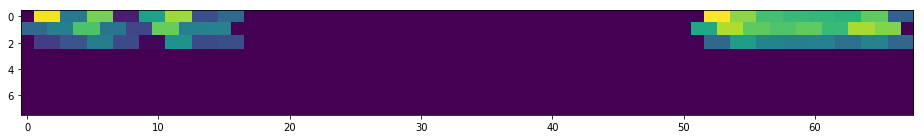

In [97]:
## SCRIVI QUI
events = events[events['TDC_CHANNEL']<129]
print(events['TDC_CHANNEL'].max())
raw_mat = np.zeros((16, 32))


plt.figure(figsize=(16,10))



rows = np.array((events['CHAMBER']-1)*4+events['LAYER']-1)
columns = np.array((events['CELL']-1)*2).astype(int)


for i in range(len(rows)):
    raw_mat[rows[i], columns[i]] = raw_mat[rows[i], columns[i]]+1
    raw_mat[rows[i], columns[i]+1] = raw_mat[rows[i], columns[i]+1]+1

#plt.imshow(raw_mat)
#plt.colorbar()

final_mat = np.zeros((8, 68))

for i in range(4):
    if (i%2 == 0):
        final_mat[i, 1:33] = raw_mat[i, :32]
    else:
        final_mat[i, :32] = raw_mat[i, :32]
for i in range(4, 8):
    if (i%2 == 0):
        final_mat[i-4, 36:68] = raw_mat[i, :32]
    else:
        final_mat[i-4, 35:67] = raw_mat[i, :32]    
#final_mat[0, 1:33] = raw_mat[0, :32]
#final_mat[1, :32] = raw_mat[1, :32]
#final_mat[2, 1:33] = raw_mat[2, :32]

plt.imshow(final_mat)


In [40]:
events.head(100)
np.array(rows)

8

In [ ]:
# Before this we have to solve the left/right ambiguity
# Add offset to the position
mask_layer = (events['LAYER'] == 1) | (events['LAYER'] == 3)
mask = mask_layer & (events['POSITION'] != 0)
events.loc[mask, 'POSITION'] = events['POSITION'] + pos_offset

In [ ]:
## Beware mortals, Marco has tamed the wild filter function!

grouped_orbit = data.groupby('ORBIT_CNT')
triggered_orbit = grouped_orbit.filter(lambda x: x['TDC_CHANNEL'].max()==139)
## Triggered_orbit è un dataframe contente tutti gli hit delle orbit che hanno il trigger 139
## Ci mette molto anche usando filter (meno di 5 minuti però, credo...)
triggered_orbit.head()
## Le orbit sembrano già essere in ordine crescente

In [ ]:
## TEST OCIO CHE CI METTE TANTISSIMISSIMO (Per ora teniamo quello di Boet)
## Lets costruiamo questo fucking dataframe
events = pd.DataFrame(columns=['EVENT','HIT','INFO','VALUE'])

## Eliminiamo le hit corrispondenti ai trigger
triggered_orbit = triggered_orbit[triggered_orbit['TDC_CHANNEL']<137]
gr_event = triggered_orbit.groupby('ORBIT_CNT')
 
## Ocio che ci mette molto tempo
event_counter = 0
row_counter = 0
for orb, group in gr_event:
    hit_counter = 1
    for row, data in group.iterrows():
        events.loc[row_counter] = [event_counter,hit_counter,'CHAMBER',data['CHAMBER']]
        events.loc[row_counter+1] = [event_counter,hit_counter,'LAYER',data['LAYER']]
        events.loc[row_counter+2] = [event_counter,hit_counter,'CELL',data['CELL']]
        events.loc[row_counter+3] = [event_counter,hit_counter,'POSITION',1]
        hit_counter += 1
        row_counter += 4
    event_counter += 1    
events.head()
## FUCK YEAH!

In [ ]:
## Lets costruiamo questo fucking dataframe
events = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL'])

## Eliminiamo le hit corrispondenti ai trigger
triggered_orbit = triggered_orbit[triggered_orbit['TDC_CHANNEL']<137]
gr_event = triggered_orbit.groupby('ORBIT_CNT')
 
## Ocio che ci mette molto tempo
c = 0
for orb, gr in gr_event:
    for i in range(len(gr)):
        events.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL']).astype(int)]
    c+=1    
events.head()
## FUCK YEAH!

In [ ]:
## Adesso voglio provare a visualizzare i risultati: ogni chamber sarà una matrice 32x132
## --> 4 righe di altezza, 16 di larghezza
## Comincio da una matrice nulla, sommo 1 alla cella in cui ho l'hit
## Devo ricordarmi che ho gli strati sfalsati, con riferimento all'immagine
## --> Conviene riempire la matrice normalmente lasciando libera l'ultima "mezza cella", e poi shiftare i risultati
mat_ch1 = mat_ch2 = mat_ch3 = mat_ch4 = np.zeros((32,132))

In [ ]:
## TUTTO OK FINO A QUA
# Create DataFrame for the event
events = pd.DataFrame(columns=['ORBIT','CHAMBER','LAYER','CELL','POSITION'])

# Sort data according their orbit and their cell
data_sorted = data.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])


# VERY SLOW
pattern = [1,2,3,4]
data_sorted.rolling(len(pattern)).apply(lambda x: all(np.equal(x, pattern)))
matched = matched.sum(axis = 1).astype(bool)
print(matched)

In [ ]:
# Now I can group hits according to the orbit
grouped_orbit = data.groupby(['ORBIT_CNT'])

index = 0
# At this point all the hits are grouped according to their orbit,
# so we have to distinguish which of them form an event
for key, group in grouped_orbit: # For every group
    # Check if there is the trigger inside the hits group
    flag = group['CELL'] == 139;
    # If there are more than 5 hits and there is the trigger
    if group.shape[0] >= 5 and flag.any():
        # Sort group by cell number
        group.sort_values(by = 'CELL')
        index += 1

## PART 2
Now we have to find the events without the help of the trigger (139) and to do so we will use the mean time trigger as follow

In [ ]:
# CAVEAT:
# This method can fail if there is a lot of noise
# Sort the DataFrame
data = data.sort_values(by = ['ORBIT_CNT','TDC_CHANNEL'])

# TODO: Remove all the triggers 137, 138, 139 

data['T1'] = data['TIME_NS']
data['T2'] = data['TIME_NS'].shift(1)
data['T3'] = data['TIME_NS'].shift(2)

# TODO: Remove rows with NaN

# Compute T 
# TODO: Missing t0
data['T0'] = (data['T1'] - data['T3'])/2 + data['T2'] - Tmax

# Look for T = Tmax and there there will be an event

data.head(20)

In [ ]:
## Nuova test section
test = triggered_orbit
test = test[test['TDC_CHANNEL']!=139]gr_test = test.groupby('ORBIT_CNT')

c = 0

for orb, gr in gr_test:
    events.loc[c] = [orb, np.array(gr['CHAMBER']), np.array(gr['LAYER']), np.array(gr['CELL']).astype(int)]
    c+=1
    
    
events.head()